### 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **라이브러리 임포트**

In [ ]:
!pip install pydub resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 54.1 MB/s eta 0:00:00


In [ ]:
import IPython.display as ipd
import librosa
import librosa.display
import pandas as pd
import os, time, warnings
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
)
from scipy.fft import fft, fftfreq
from pydub import AudioSegment
import matplotlib as mpl
from scipy.signal import stft
warnings.filterwarnings("ignore")


# **MFCC Visualization**


In [ ]:
plt.rcParams["figure.figsize"] = (5, 3)
plt.rcParams["figure.dpi"] = 100

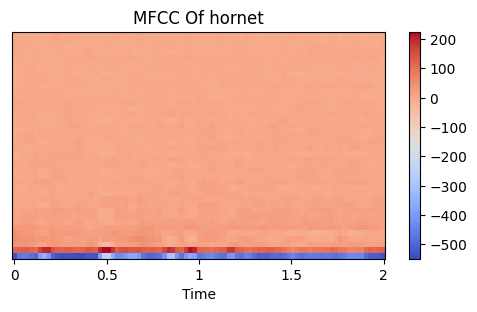

In [ ]:
audio_path = '/content/drive/MyDrive/test/data/split_sound/hornet_1/345508__soundtracvkradio__wasp_part0.mp3'
(xf, sr) = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis="time")
plt.colorbar()
plt.tight_layout()
plt.title("MFCC Of hornet")
plt.show()

# **Data Preprocessing**


**오디오 파일 불러온뒤 MFCC 적용**

In [ ]:
# list containing all the features
extracted = []
# Define the audio dataset path
audio_dataset_path = "/content/drive/MyDrive/sound"

# List the folders (classes) in the dataset path
class_folders = [f for f in os.listdir(audio_dataset_path) if os.path.isdir(os.path.join(audio_dataset_path, f))]

# Process each class folder
for class_name in class_folders:
    class_path = os.path.join(audio_dataset_path, class_name)

    # List the first 10 audio files in each class folder
    audio_files = os.listdir(class_path)[:]

    # Process each audio file
    for audio_file in tqdm(audio_files, desc=f"Processing {class_name}"):
        file_path = os.path.join(class_path, audio_file)

        # Load the audio file
        audio, sample_rate = librosa.load(file_path, res_type="kaiser_fast")

        # Extract the features
        feature = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)

        # Feature scaling
        scaled_feature = np.mean(feature.T, axis=0)

        # Store the features and class labels in a list
        extracted.append([scaled_feature, class_name])

# Create a new dataframe
extracted_df = pd.DataFrame(extracted, columns=["feature", "class"])

# Storing the dataframe to pickle for further processing
extracted_df.to_pickle("extracted_df.pkl")

# Display the first few rows of the dataframe
extracted_df.head()


**데이터 불러오기**

In [ ]:
final = pd.read_pickle("/content/drive/MyDrive/extracted_df.pkl")
X = np.array(final["feature"])
y = np.array(final["class"])

**라벨 인코딩**

In [ ]:
# label encoding to get encoding
le = LabelEncoder()

# transform each category with it's respected label
Y = to_categorical(le.fit_transform(y))

## Split the data into train and test sets


In [ ]:
# split the data to train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# print the details
print("Number of training samples = ", X_train.shape)
print("Number of testing samples = ", X_test.shape[0])

Number of training samples =  (21857,)
Number of testing samples =  5465


# **Model**

모델별 성능 저장

In [ ]:
log_cols = ["model", "accuracy", "train_time", "pred_time"]
log = pd.DataFrame(columns=log_cols)

## **Model 1 - ANN**


In [ ]:
# Construct model
num_labels = Y.shape[1]
ANN_Model = Sequential()
ANN_Model.add(Dense(1000, activation="relu", input_shape=(128,)))
ANN_Model.add(Dense(750, activation="relu"))
ANN_Model.add(Dense(500, activation="relu"))
ANN_Model.add(Dense(250, activation="relu"))
ANN_Model.add(Dense(100, activation="relu"))
ANN_Model.add(Dense(50, activation="relu"))
ANN_Model.add(Dense(num_labels, activation="softmax"))
ANN_Model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1000)                │         129,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 750)                 │         750,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 500)                 │         375,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 250)                 │         125,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │          25,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,410,752 (5.38 MB)

 Trainable params: 1,410,752 (5.38 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model


In [ ]:
ANN_Model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

### Fitting the model


In [ ]:
num_epochs = 250
num_batch_size = 32

t0 = time.time()

ANN_Results = ANN_Model.fit(
    X_train,
    y_train,
    batch_size=num_batch_size,
    epochs=num_epochs,
    validation_data=(X_test, y_test),
)

ANN_Model.save("Model1.h5")
print("ANN Model Saved")
train_hist_m1 = pd.DataFrame(ANN_Results.history)
train_m1 = round(time.time() - t0, 3)


Epoch 1/250
684/684 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9325 - loss: 0.6960 - val_accuracy: 0.9253 - val_loss: 0.1375
Epoch 2/250
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9754 - loss: 0.0921 - val_accuracy: 0.9885 - val_loss: 0.0469
Epoch 3/250
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9905 - loss: 0.0300 - val_accuracy: 0.9971 - val_loss: 0.0075
Epoch 4/250
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9960 - loss: 0.0121 - val_accuracy: 0.9980 - val_loss: 0.0078
Epoch 5/250
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9961 - loss: 0.0139 - val_accuracy: 0.9980 - val_loss: 0.0067
Epoch 6/250
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9962 - loss: 0.0126 - val_accuracy: 0.9978 - val_loss: 0.0080
Epoch 7/250
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9946 - loss: 0.0274 - val_accuracy: 0.9938 - val_loss: 0.0189
Epoch 8/250
684/684 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9978 - loss: 0.0071 - val_accu

ANN Model Saved


### Results


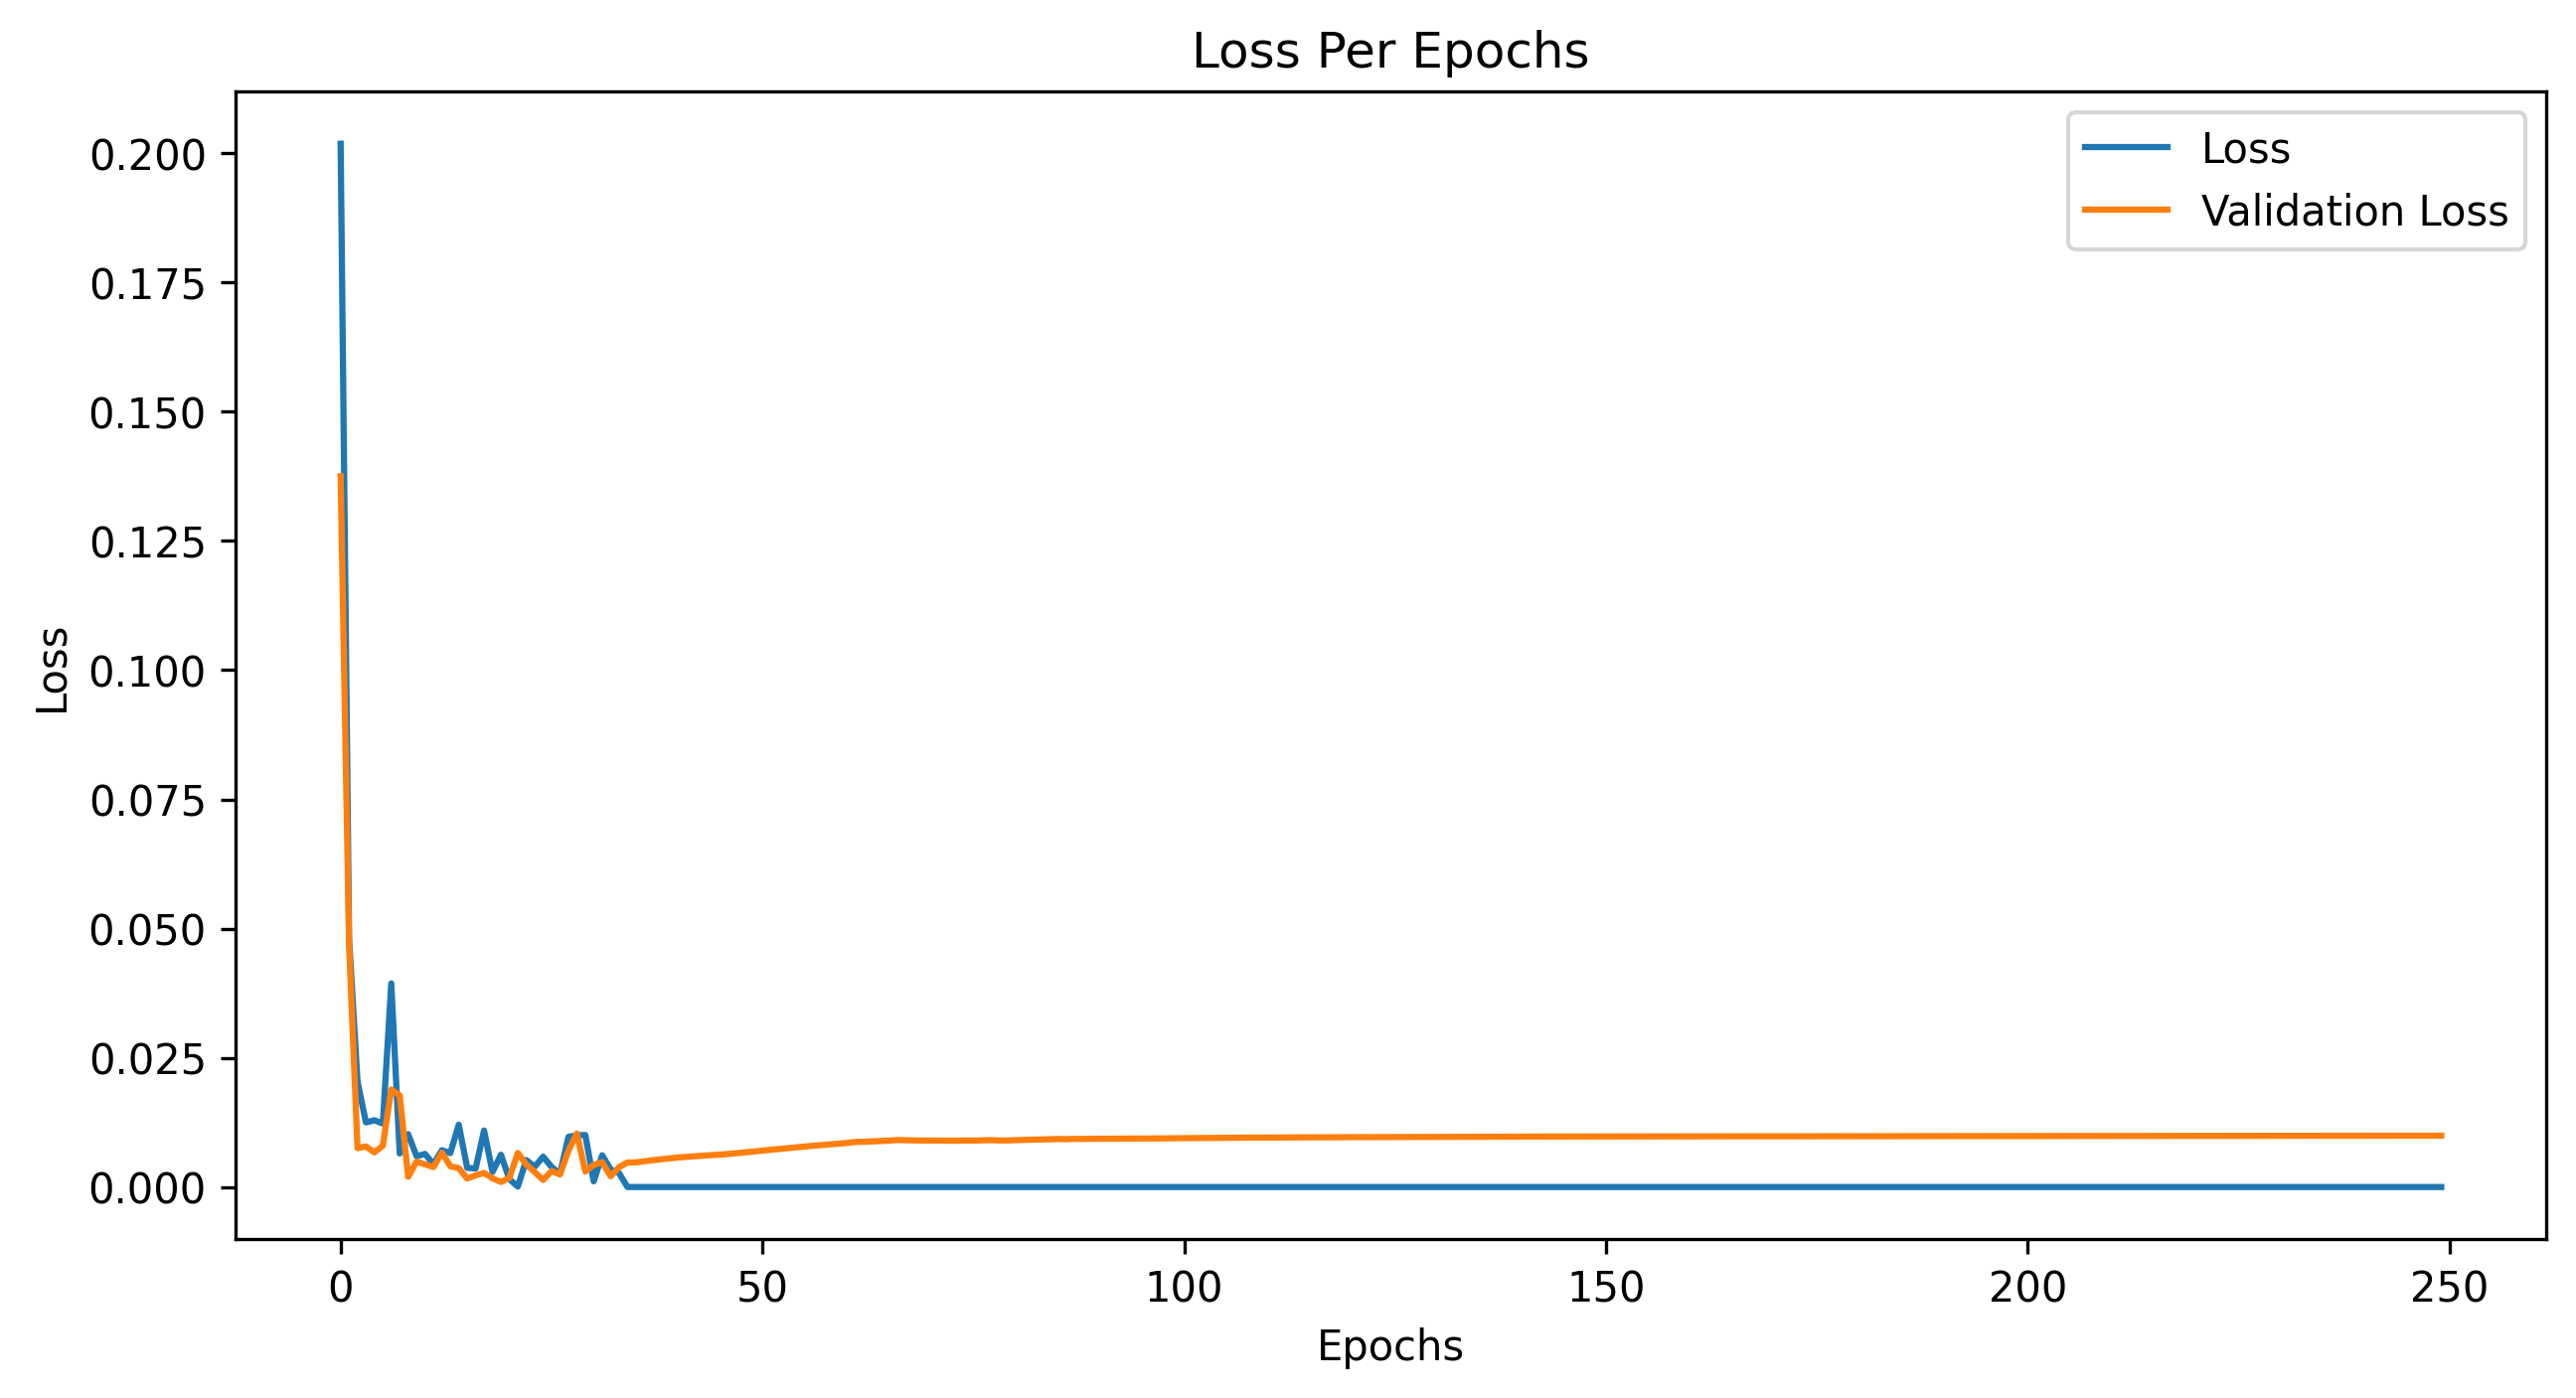

In [ ]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m1[["loss", "val_loss"]])
plt.legend(["Loss", "Validation Loss"])
plt.title("Loss Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

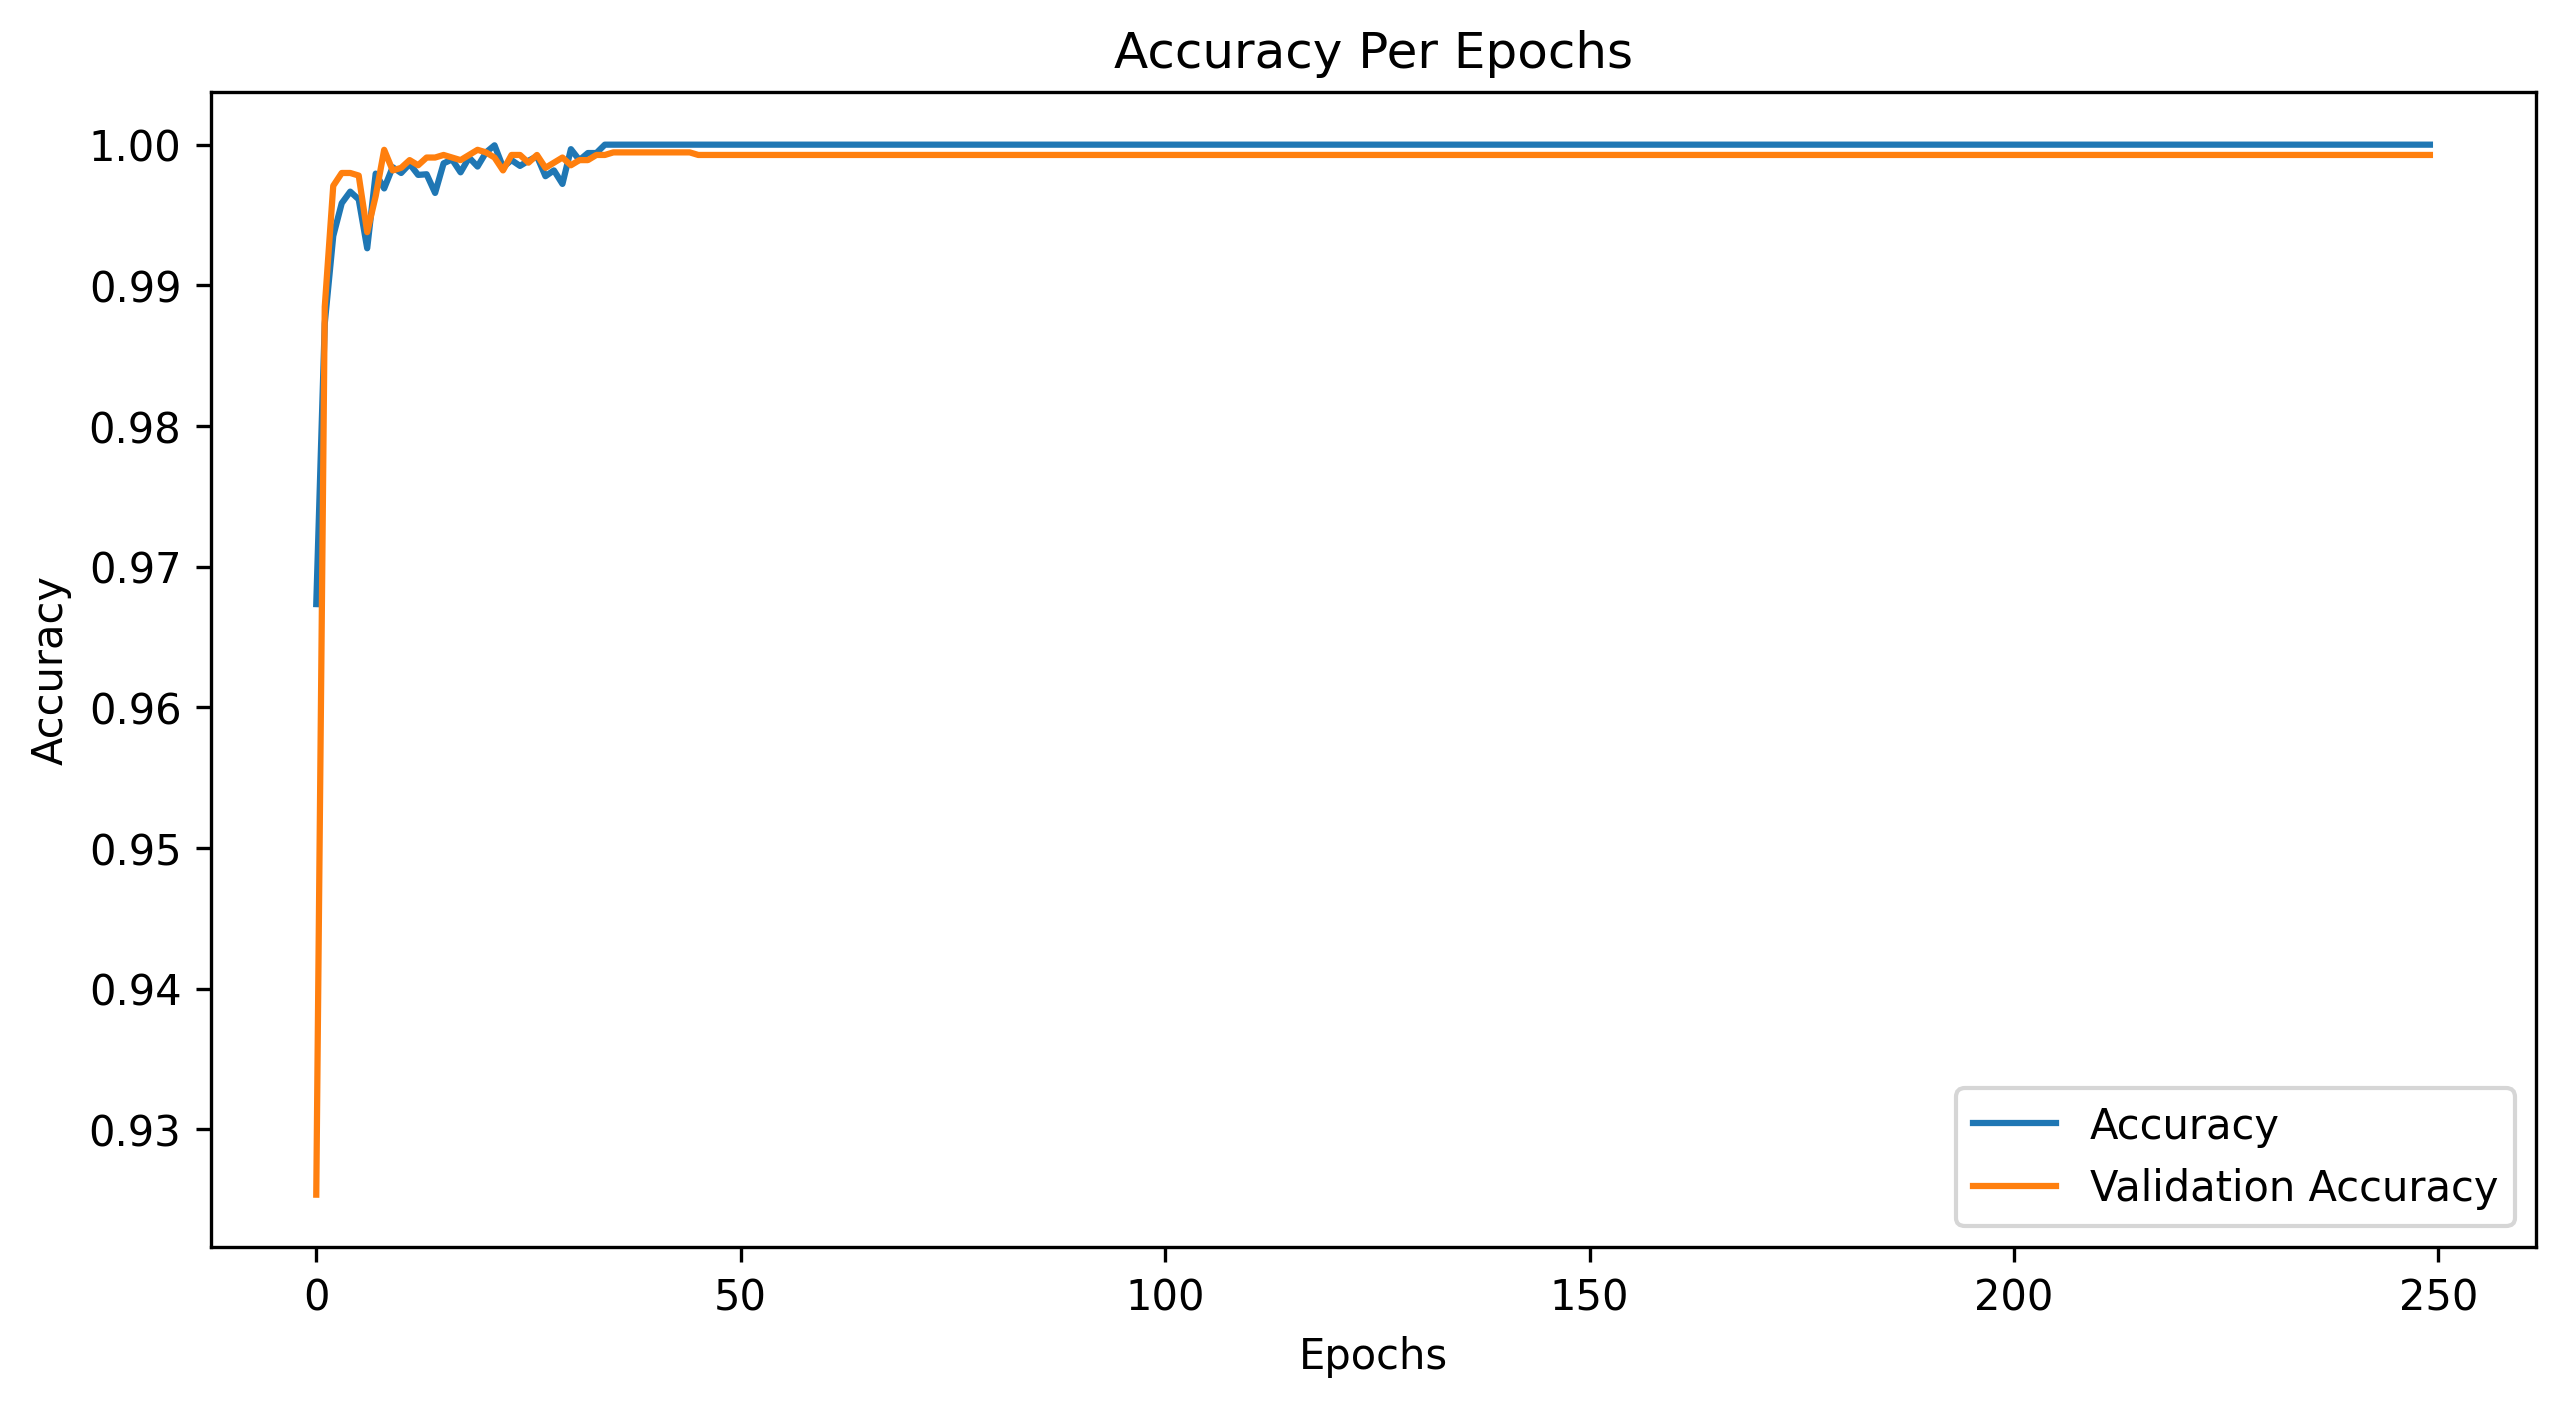

In [ ]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m1[["accuracy", "val_accuracy"]])
plt.legend(["Accuracy", "Validation Accuracy"])
plt.title("Accuracy Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


In [ ]:
acc_m1 = ANN_Model.evaluate(X_test, y_test, verbose=0)
t0 = time.time()
y_pred_m1 = ANN_Model.predict(X_test, verbose=0)
pred_m1 = round(time.time() - t0, 3)
log_entry = pd.DataFrame(
    [["ANN", acc_m1[1] * 100, train_m1, pred_m1]], columns=log_cols
)
# 기존 로그에 새로운 항목 추가
log = pd.concat([log, log_entry], ignore_index=True)

### ANN Prediction Function


In [ ]:
# function to predict the feature
def ANN_Prediction(file_name):
    # load the audio file
    audio_data, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
    # get the feature
    feature = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=128)
    # scale the features
    feature_scaled = np.mean(feature.T, axis=0)
    # array of features
    prediction_feature = np.array([feature_scaled])
    # get the id of label using argmax
    predicted_vector = np.argmax(ANN_Model.predict(prediction_feature), axis=-1)
    # get the class label from class id
    predicted_class = le.inverse_transform(predicted_vector)
    # display the result
    print("ANN has predicted the class as  --> ", predicted_class[0])


### Testing the Model on Sample audio


In [ ]:
# File name
file_name = "/content/drive/MyDrive/sound/hornet/398487__wakerone__wasp-wings-2.wav"
# get the output
ANN_Prediction(file_name)
# play the file
ipd.Audio(file_name)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/sound/hornet/398487__wakerone__wasp-wings-2.wav'

## **Model 2 - CNN1D**

### Preprocessing


In [ ]:
xTrainval, xTest, yTrainval, yTest = train_test_split(
    X, Y, test_size=0.1, stratify=y, random_state=387
)
xTrain, xvalid, yTrain, yvalid = train_test_split(
    xTrainval, yTrainval, test_size=0.2, stratify=yTrainval, random_state=387
)
print("\nNumber of samples for Train set :", xTrain.shape[0])
print("Number of samples for Validation set :", xvalid.shape[0])
print("Number of samples for Test set :", xTest.shape[0])

xTrain = np.expand_dims(xTrain, axis=2)
xvalid = np.expand_dims(xvalid, axis=2)

print("Shape of X Train", xTrain.shape)
print("Shape of X Test", xTest.shape)



Number of samples for Train set : 19671
Number of samples for Validation set : 4918
Number of samples for Test set : 2733


AxisError: axis 2 is out of bounds for array of dimension 2

### Building the CNN1D Model


In [ ]:
CNN1D_Model = Sequential()
CNN1D_Model.add(
    Conv1D(
        256,
        5,
        strides=1,
        padding="same",
        activation="relu",
        input_shape=(xTrain.shape[1], 1),
    )
)
CNN1D_Model.add(BatchNormalization())
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(256, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(128, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(64, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Flatten())
CNN1D_Model.add(Dense(units=1024, activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(Dense(units=2, activation="softmax"))
CNN1D_Model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 128, 256)            │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 64, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 64, 256)             │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 32, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 32, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 16, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 8, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,062,850 (4.05 MB)

 Trainable params: 1,062,338 (4.05 MB)

 Non-trainable params: 512 (2.00 KB)

### Compiling the Model


In [ ]:
CNN1D_Model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)


### Fitting the Model


In [ ]:
t0 = time.time()

CNN1D_Results = CNN1D_Model.fit(
    xTrain, yTrain, batch_size=64, epochs=250, validation_data=(xvalid, yvalid)
)

CNN1D_Model.save("Model2.h5")
print("CNN1D Model Saved")
train_hist_m2 = pd.DataFrame(CNN1D_Results.history)
train_m2 = round(time.time() - t0, 3)


Epoch 1/250
308/308 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9293 - loss: 0.3084 - val_accuracy: 0.9764 - val_loss: 0.0611
Epoch 2/250
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9803 - loss: 0.0604 - val_accuracy: 0.9880 - val_loss: 0.0377
Epoch 3/250
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9831 - loss: 0.0496 - val_accuracy: 0.9866 - val_loss: 0.0318
Epoch 4/250
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9887 - loss: 0.0408 - val_accuracy: 0.9896 - val_loss: 0.0285
Epoch 5/250
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9900 - loss: 0.0298 - val_accuracy: 0.9933 - val_loss: 0.0230
Epoch 6/250
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9938 - loss: 0.0193 - val_accuracy: 0.9904 - val_loss: 0.0262
Epoch 7/250
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9896 - loss: 0.0293 - val_accuracy: 0.9931 - val_loss: 0.0185
Epoch 8/250
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9927 - loss: 0.0230 - val_ac

CNN1D Model Saved


### Results


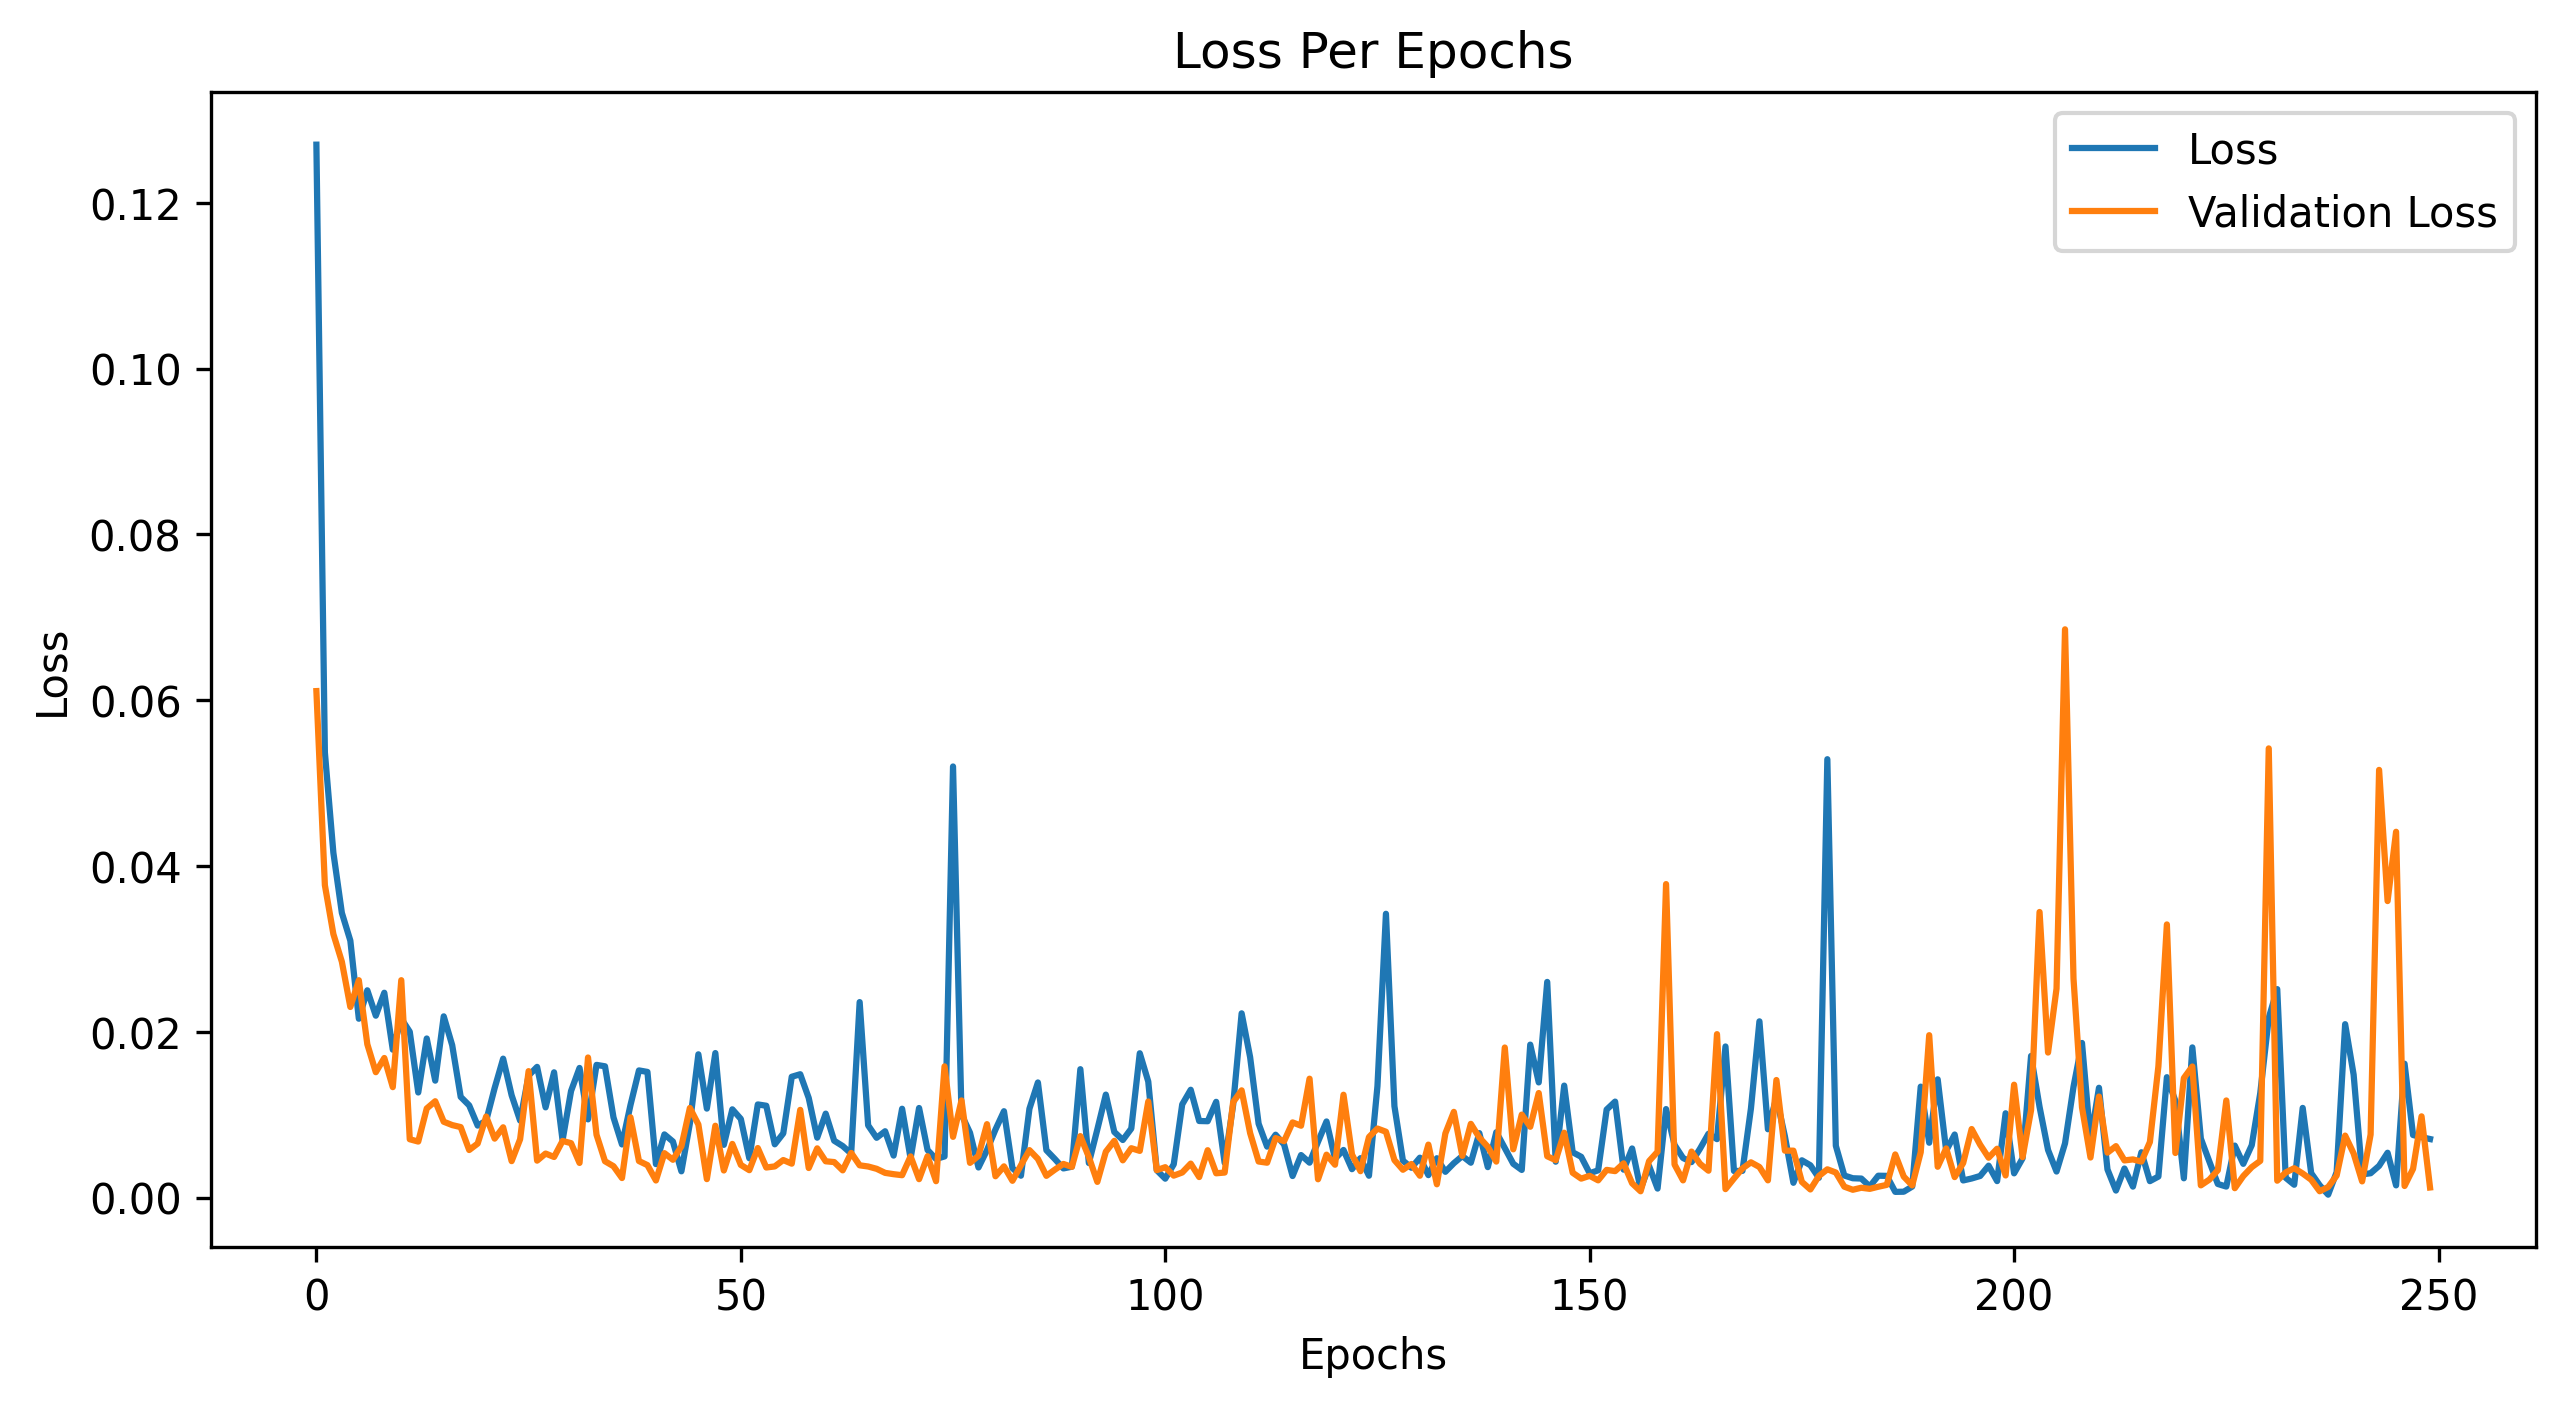

In [ ]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m2[["loss", "val_loss"]])
plt.legend(["Loss", "Validation Loss"])
plt.title("Loss Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

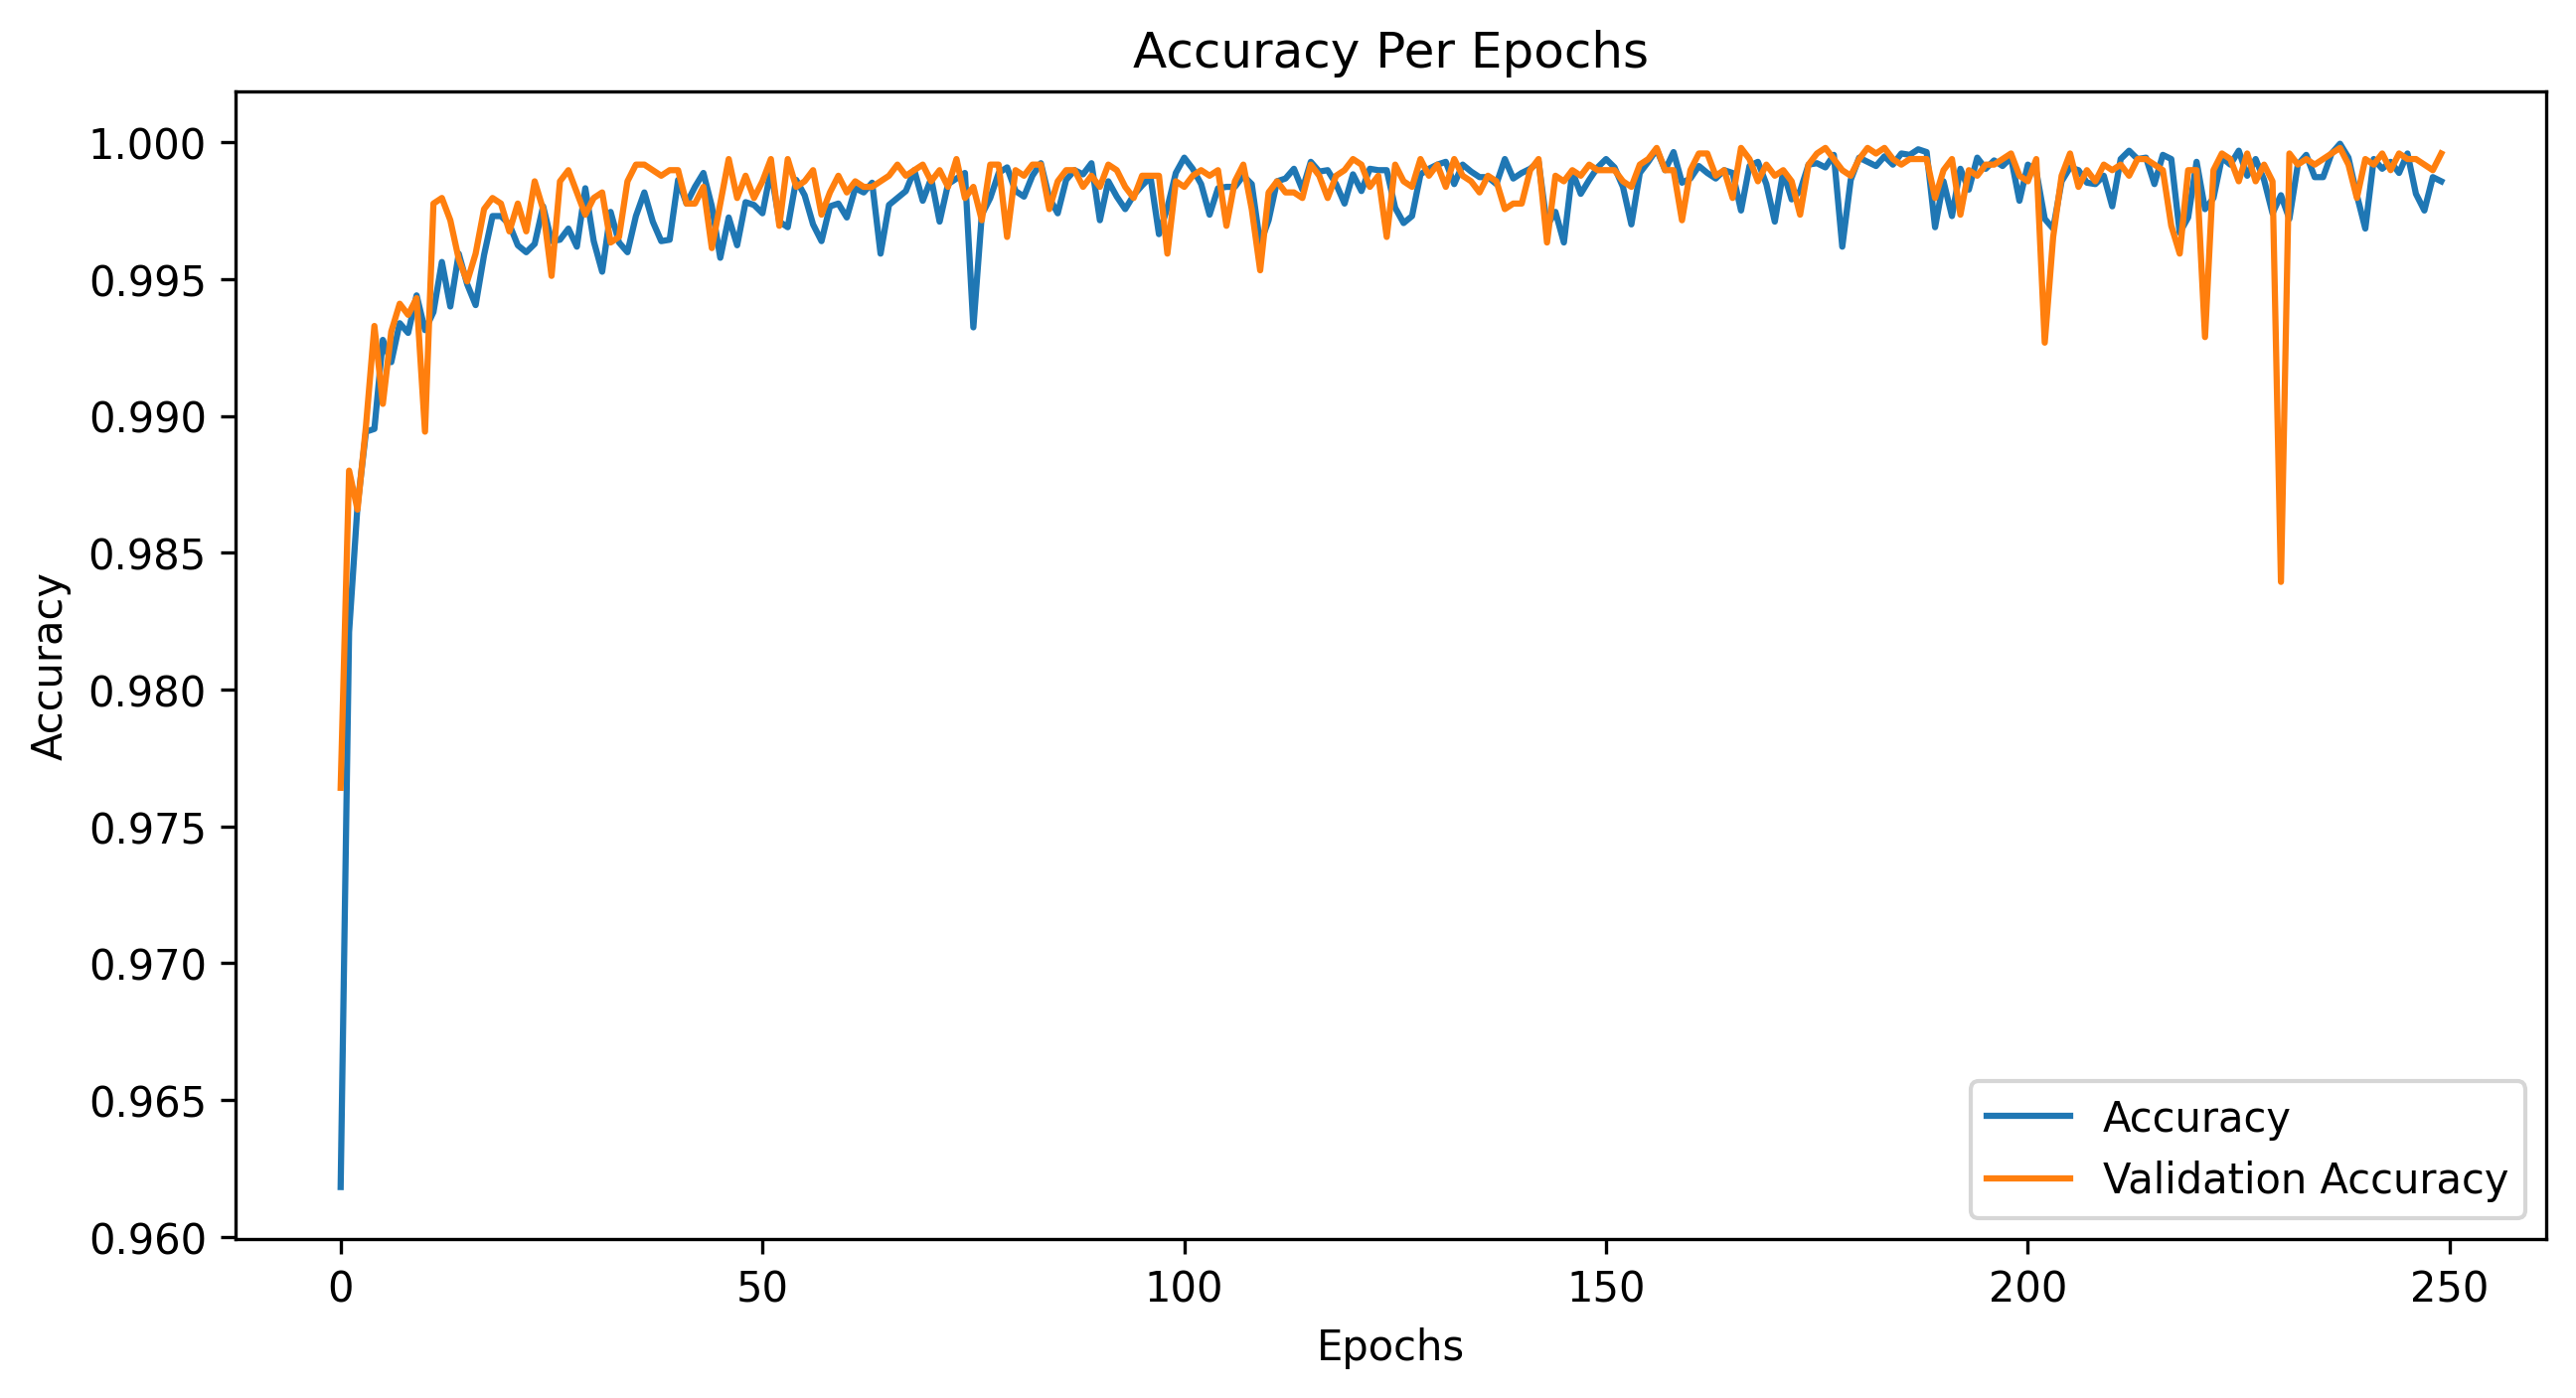

In [ ]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m2[["accuracy", "val_accuracy"]])
plt.legend(["Accuracy", "Validation Accuracy"])
plt.title("Accuracy Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


In [ ]:
acc_m2 = CNN1D_Model.evaluate(xvalid, yvalid, verbose=0)
t0 = time.time()
y_pred_m2 = CNN1D_Model.predict(xvalid, verbose=0)
pred_m2 = round(time.time() - t0, 3)
log_entry = pd.DataFrame(
    [["CNN1D", acc_m2[1] * 100, train_m2, pred_m2]], columns=log_cols
)
# 기존 로그에 새로운 항목 추가
log = pd.concat([log, log_entry], ignore_index=True)


### CNN1D Prediction Function


In [ ]:
# function to predict the feature
def CNN1D_Prediction(file_name):
    # load the audio file
    audio_data, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
    # get the feature
    feature = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=128)
    # scale the features
    feature_scaled = np.mean(feature.T, axis=0)
    # array of features
    prediction_feature = np.array([feature_scaled])
    # expand dims
    final_prediction_feature = np.expand_dims(prediction_feature, axis=2)
    # get the id of label using argmax
    predicted_vector = np.argmax(CNN1D_Model.predict(final_prediction_feature), axis=-1)
    # get the class label from class id
    predicted_class = le.inverse_transform(predicted_vector)
    # display the result
    print("CNN1D has predicted the class as  --> ", predicted_class[0])


### Testing the Model on Sample audio


In [ ]:
# File name
file_name = "/content/drive/MyDrive/sound/hornet/398487__wakerone__wasp-wings-2.wav"
# get the output
CNN1D_Prediction(file_name)
# play the file
ipd.Audio(file_name)


## **Model 3 - CNN2D**


### Preprocessing


In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(
    X, Y, test_size=0.1, stratify=y, random_state=387
)
xTrain, xvalid, yTrain, yvalid = train_test_split(
    xTrainval, yTrainval, test_size=0.2, stratify=yTrainval, random_state=387
)
print(xTrain.shape)
xtrain = xTrain.reshape(xTrain.shape[0], 16, 8, 87)
xtest = xTest.reshape(xTest.shape[0], 16, 8, 87)

print("The Shape of X Train", xtrain.shape)
print("The Shape of Y Train", yTrain.shape)
print("The Shape of X Test", xtest.shape)
print("The Shape of Y Test", yTest.shape)


(128, 87)


ValueError: cannot reshape array of size 19671 into shape (19671,16,8,87)

### Building the CNN2D Model


In [ ]:
CNN2D_Model = Sequential()
CNN2D_Model.add(
    Conv2D(64, (3, 3), padding="same", activation="tanh", input_shape=(16, 8, 1))
)
CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model.add(Conv2D(128, (3, 3), padding="same", activation="tanh"))
CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model.add(Dropout(0.1))
CNN2D_Model.add(Flatten())
CNN2D_Model.add(Dense(1024, activation="tanh"))
CNN2D_Model.add(Dense(2, activation="softmax"))
CNN2D_Model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 16, 8, 64)           │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 8, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 4, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,126,146 (4.30 MB)

 Trainable params: 1,126,146 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model


In [ ]:
CNN2D_Model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)


### Fitting the Model


In [ ]:
t0 = time.time()

CNN2D_Results = CNN2D_Model.fit(
    xtrain, yTrain, epochs=250, batch_size=50, validation_data=(xtest, yTest)
)

CNN2D_Model.save("Model3.h5")
print("CNN2D Model Saved")
train_hist_m3 = pd.DataFrame(CNN2D_Results.history)
train_m3 = round(time.time() - t0, 3)


Epoch 1/250
394/394 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9528 - loss: 0.2005 - val_accuracy: 0.9930 - val_loss: 0.0230
Epoch 2/250
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9971 - loss: 0.0119 - val_accuracy: 0.9916 - val_loss: 0.0380
Epoch 3/250
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9951 - loss: 0.0188 - val_accuracy: 0.9985 - val_loss: 0.0042
Epoch 4/250
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9984 - loss: 0.0051 - val_accuracy: 0.9967 - val_loss: 0.0088
Epoch 5/250
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9986 - loss: 0.0045 - val_accuracy: 0.9978 - val_loss: 0.0061
Epoch 6/250
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9993 - loss: 0.0026 - val_accuracy: 0.9982 - val_loss: 0.0029
Epoch 7/250
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9974 - loss: 0.0073 - val_accuracy: 0.9982 - val_loss: 0.0035
Epoch 8/250
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9993 - loss: 0.0026 - val_acc

CNN2D Model Saved


### Results


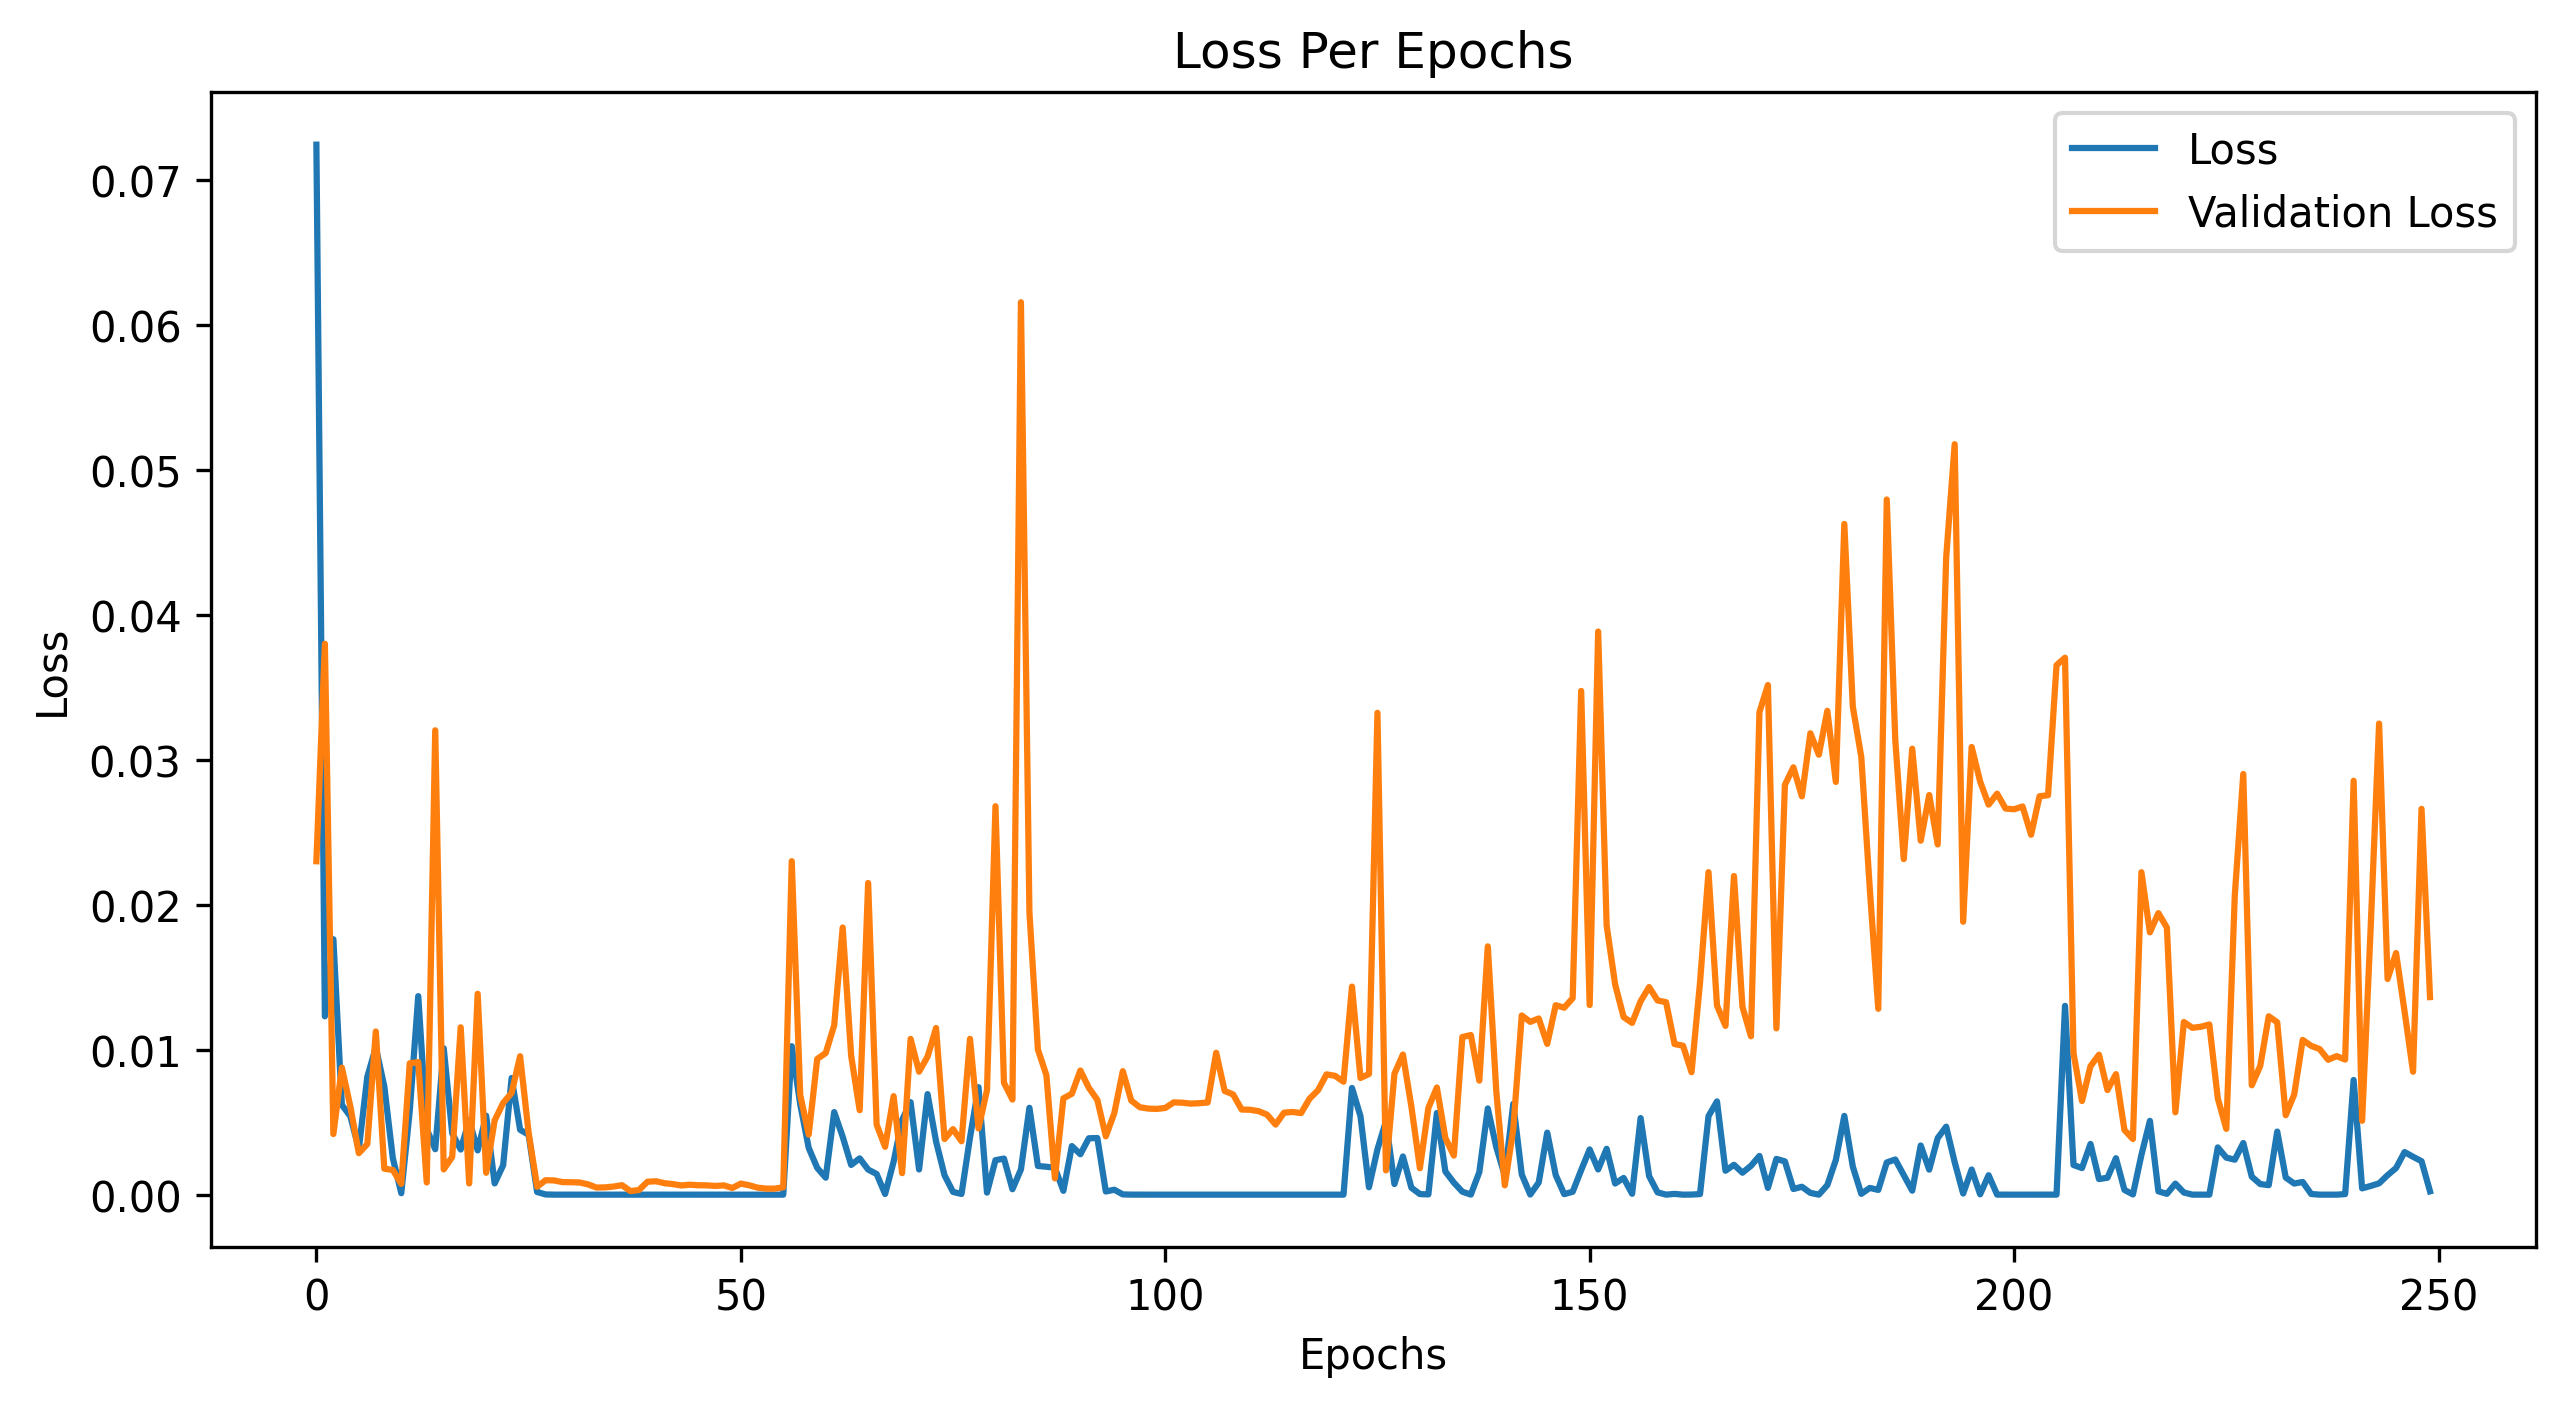

In [ ]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m3[["loss", "val_loss"]])
plt.legend(["Loss", "Validation Loss"])
plt.title("Loss Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

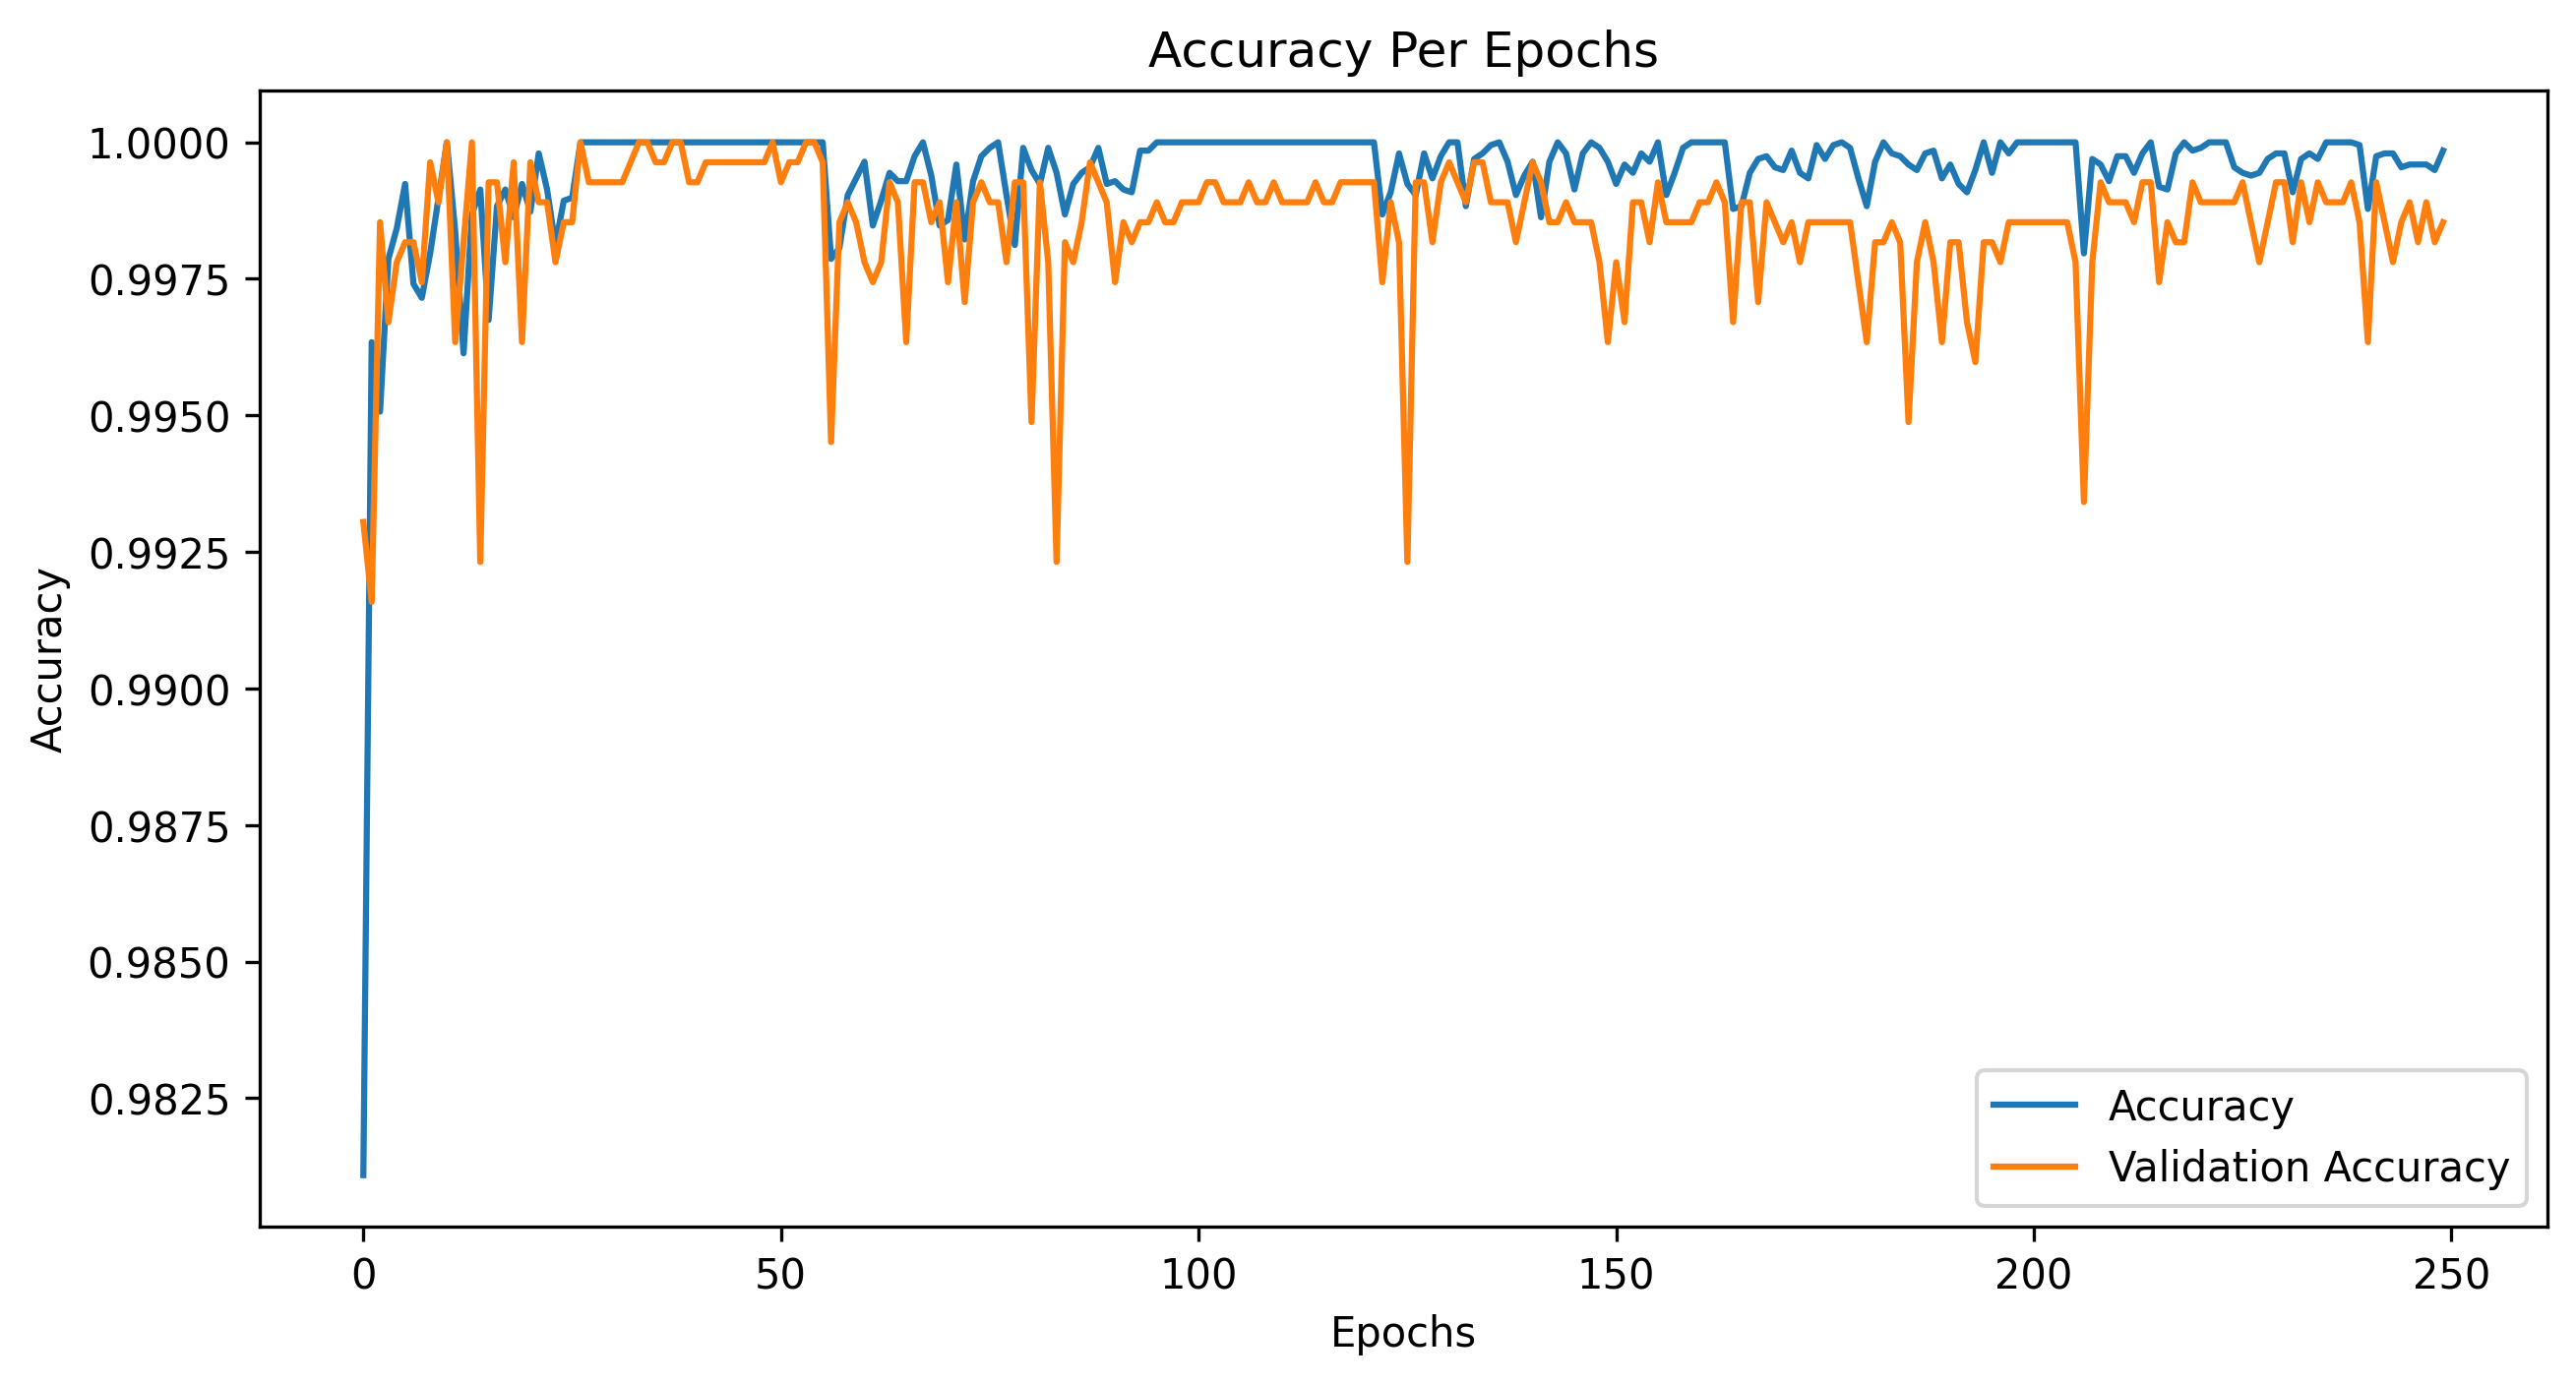

In [ ]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(train_hist_m3[["accuracy", "val_accuracy"]])
plt.legend(["Accuracy", "Validation Accuracy"])
plt.title("Accuracy Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


In [ ]:
acc_m3 = CNN2D_Model.evaluate(xtest, yTest, verbose=0)
t0 = time.time()
y_pred_m3 = CNN2D_Model.predict(xtest, verbose=0)
pred_m3 = round(time.time() - t0, 3)
log_entry = pd.DataFrame(
    [["CNN2D", acc_m3[1] * 100, train_m3, pred_m3]], columns=log_cols
)
# 기존 로그에 새로운 항목 추가
log = pd.concat([log, log_entry], ignore_index=True)


### CNN2D Prediction Function


In [ ]:
# function to predict the feature
def CNN2D_Prediction(file_name):
    # load the audio file
    audio_data, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
    # get the feature
    feature = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=128)
    # scale the features
    feature_scaled = np.mean(feature.T, axis=0)
    # array of features
    prediction_feature = np.array([feature_scaled])
    # reshaping the features
    final_prediction_feature = prediction_feature.reshape(
        prediction_feature.shape[0], 16, 8, 1
    )
    # get the id of label using argmax
    predicted_vector = np.argmax(CNN2D_Model.predict(final_prediction_feature), axis=-1)
    # get the class label from class id
    predicted_class = le.inverse_transform(predicted_vector)
    # display the result
    print("CNN2D has predicted the class as  --> ", predicted_class[0])


### Testing the Model on Sample audio


In [ ]:
# File name
file_name = "/content/drive/MyDrive/sound/bee/518691__kevp888__002b_140815_1957_fr_beesgarden.mp3"
# get the output
CNN2D_Prediction(file_name)
# play the file
ipd.Audio(file_name)


## **Comparative Analysis**


In [ ]:
plt.rcParams["figure.figsize"] = (17, 2)
plt.rcParams["figure.dpi"] = 550


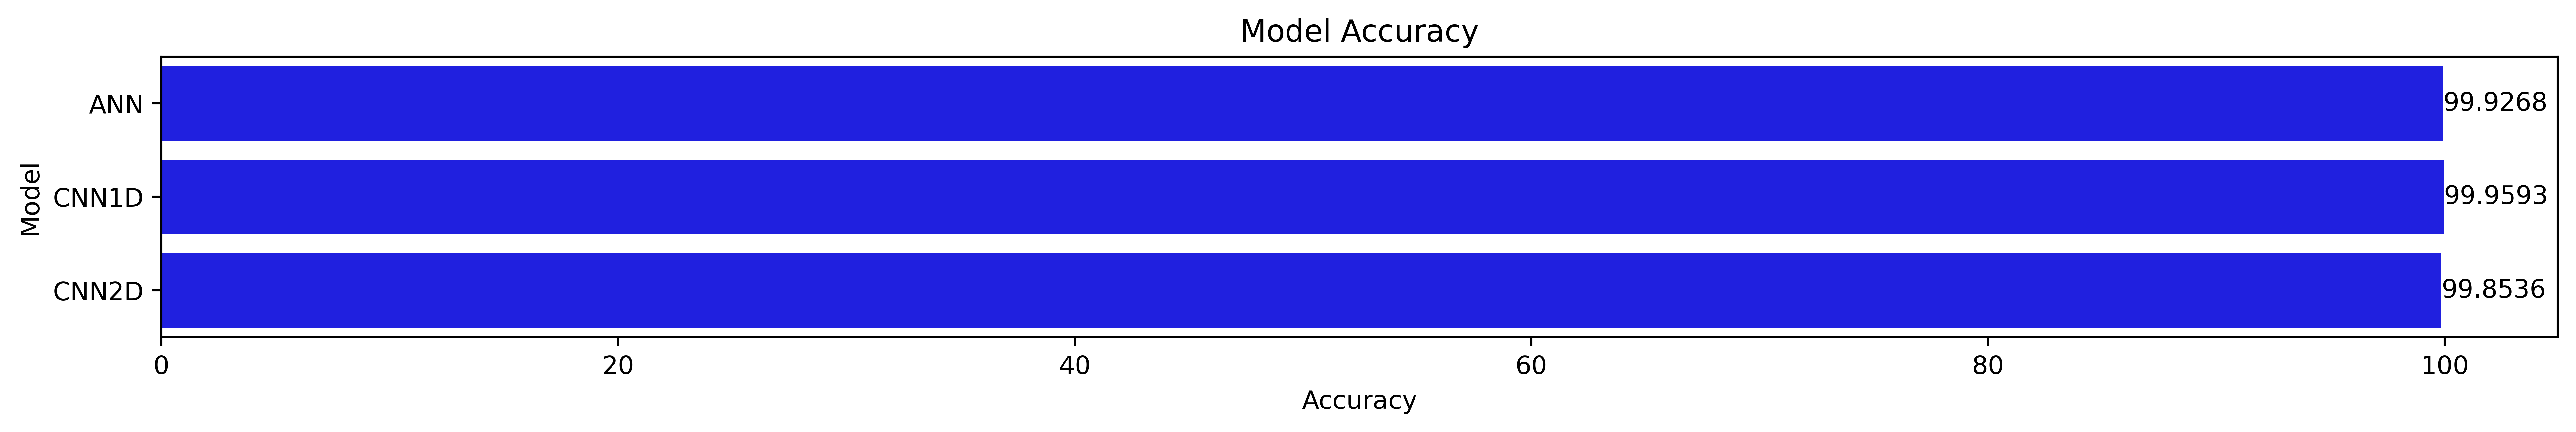

In [ ]:
ax = sns.barplot(x="accuracy", y="model", data=log, color="b")
ax.bar_label(ax.containers[0])
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.title("Model Accuracy")
plt.show()


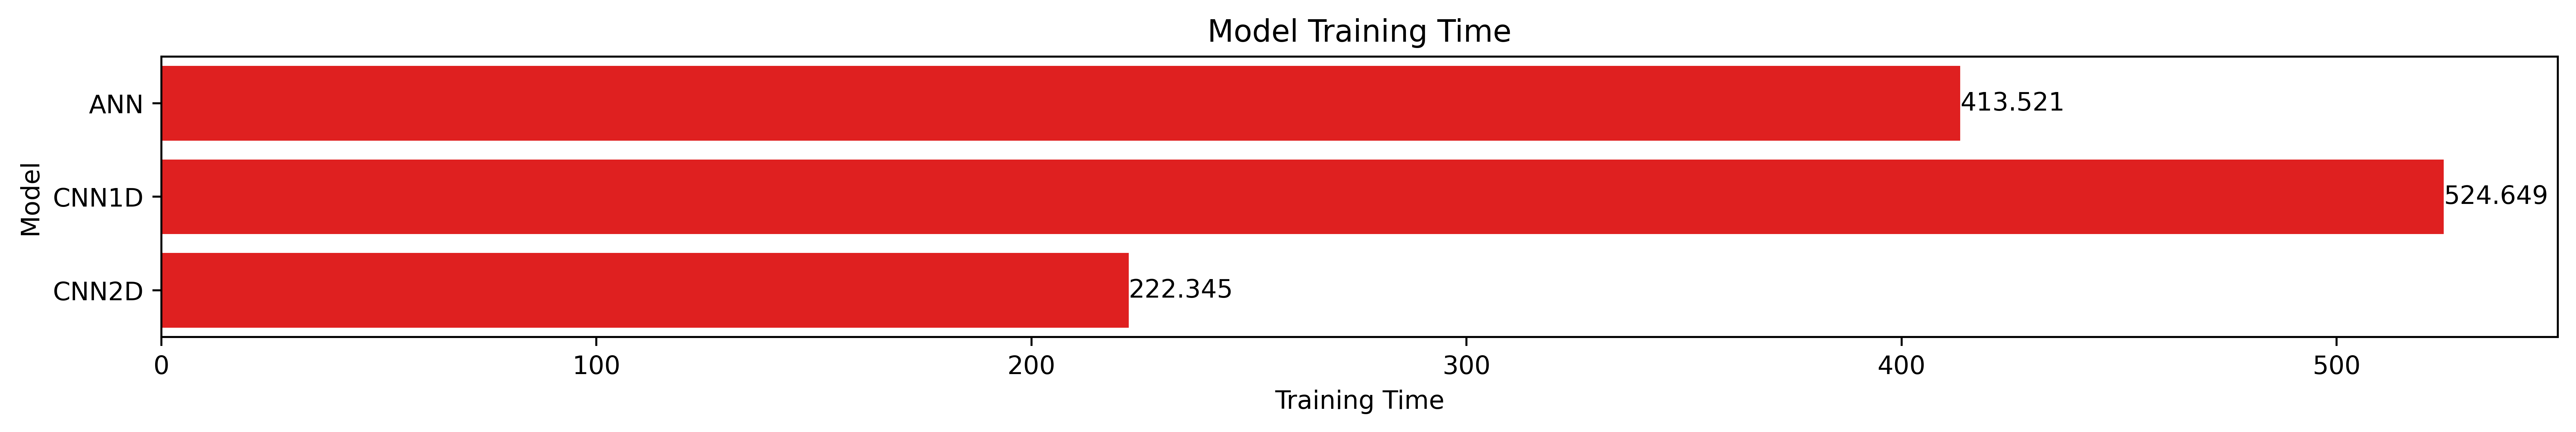

In [ ]:
ax = sns.barplot(x="train_time", y="model", data=log, color="r")
ax.bar_label(ax.containers[0])
plt.xlabel("Training Time")
plt.ylabel("Model")
plt.title("Model Training Time")
plt.show()


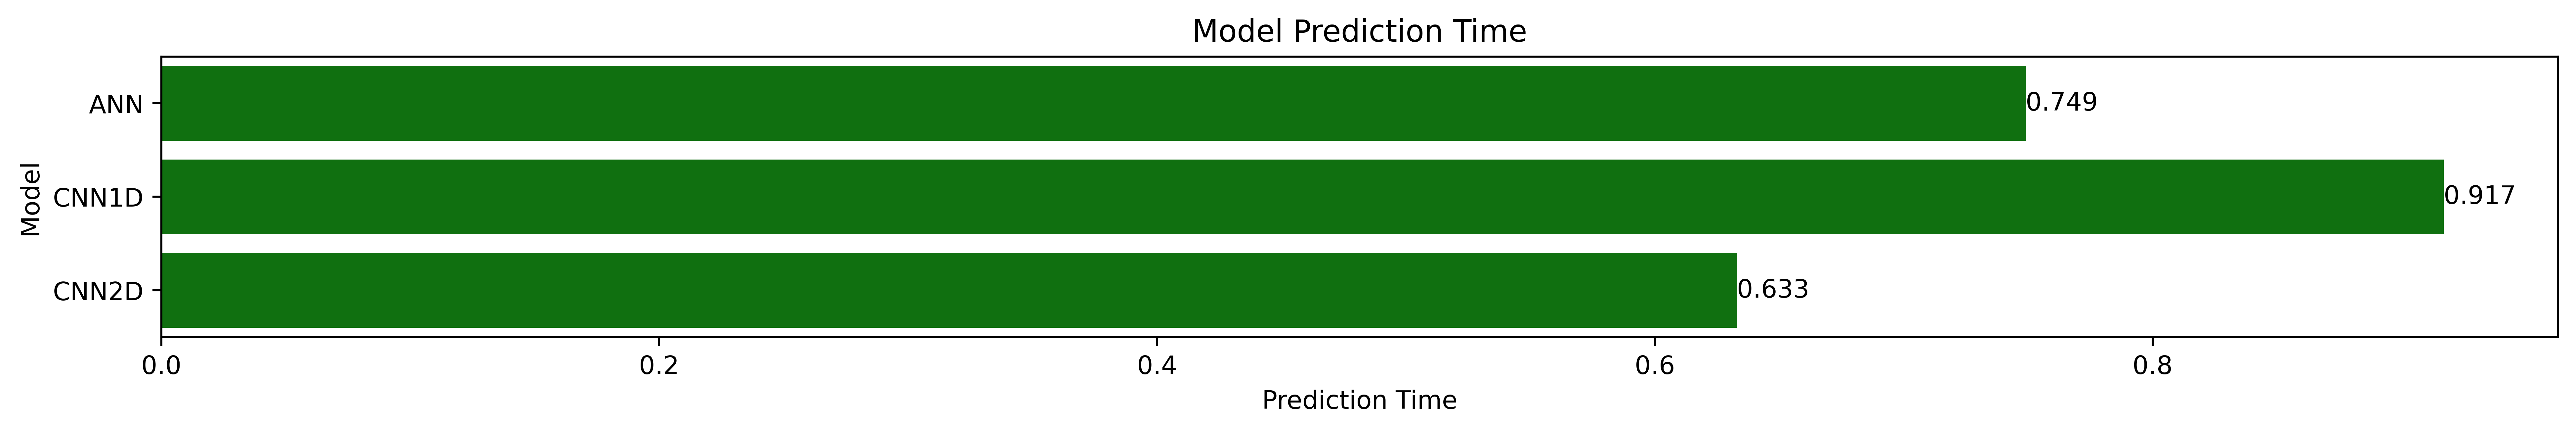

In [ ]:
ax = sns.barplot(x="pred_time", y="model", data=log, color="g")
ax.bar_label(ax.containers[0])
plt.xlabel("Prediction Time")
plt.ylabel("Model")
plt.title("Model Prediction Time")
plt.show()


In [ ]:
import shutil
import os

In [ ]:
# 이동할 파일 경로와 목적지 경로 설정
source_path = '/content/Model3.h5'
destination_path = '/content/drive/MyDrive/Model3.h5'
# 파일 이동
try:
    shutil.move(source_path, destination_path)
    print(f"파일이 성공적으로 이동되었습니다: {destination_path}")
except FileNotFoundError as e:
    print(f"파일을 찾을 수 없습니다: {e}")
except Exception as e:
    print(f"파일 이동 중 오류가 발생했습니다: {e}")

파일이 성공적으로 이동되었습니다: /content/drive/MyDrive/Model3.h5
